# Lab 2 - Analiza skupień

Analiza skupień, to jedna z kluczowych metod w analizie danych. Umożliwia identyfikację naturalnych grup lub klastrów w zestawach danych. Istotnym celem tego podejścia jest zrozumienie struktury wiedzy zawartj w danych poprzez wykrywanie podobieństw między obiektami, a także różnic między nimi.

W kontekście uczenia maszynowego, analiza skupień często wykorzystywana jest do segmentacji danych, co pozwala na lepsze zrozumienie zachowań klientów, wzorców społecznych, czy nawet struktur biologicznych. Przykładowo, w analizie danych konsumenckich, grupowanie klientów na podstawie ich preferencji zakupowych może pomóc firmom w dostosowaniu oferty do konkretnych segmentów rynku, co z kolei może przyczynić się do wzrostu sprzedaży.

Warto mieć na uwadze fakt, że analiza skupień może być również stosowana w redukcji wymiarowości danych na podstawie wyznaczania dopasowania obiektów do poszczególnych skupień. Jednym z najznamienitszych obszarów zastosowań analizy skupień jest także obszar detekcji anomalii, który może być wykorzystany zarówno w analizie danych, jak też w bardziej rzeczywistych przypadkach, jak wykrywanie nietypowych transakcji dokonywanych za pomocą kart płatniczych.

## Metody oparte na centroidach

Jednymi z najpopularniejszych podejść do analizy skupień są algorytmy oparte na centroidach.

### k-średnich


Algorytm k-średnich jest jednym z najpopularniejszych i najprostszych algorytmów do analizy skupień. Jego głównym celem jest podział zbioru danych na *k* klastrów, gdzie każdy z nich zawiera podobne do siebie obiekty, a jednocześnie różni się od pozostałych klastrów. Algorytm ten operuje na podstawie iteracyjnego procesu, w którym najpierw wybierane są losowe punkty startowe będące **centroidami** klastrów, a następnie obiekty są przypisywane do najbliższych centroidów, tworząc tym samym początkowe klastry. W kolejnych iteracjach centroidy są aktualizowane poprzez obliczenie średniej ze wszystkich obiektów przypisanych do danego klastra, a następnie obiekty są przypisywane do nowych klastrów na podstawie ich odległości od zaktualizowanych centroidów.

Istnieje wiele zalet algorytmu k-średnich, w tym jego prostota implementacji i intuicyjność działania. Jest to również algorytm o niskiej złożoności obliczeniowej, co oznacza, że ​​jest względnie wydajny nawet dla dużych zbiorów danych. Warto jednak zawuażyć że, algorytm ten posiada też pewne ograniczenia i wrażliwość na wybór losowych centroidów początkowych, co może prowadzić do różnych wyników w zależności od inicjalizacji. Ponadto, k-średnich może mieć trudności w radzeniu sobie z klastrami o złożonych kształtach, ponieważ dąży do tworzenia okrągłych klastrów wokół centroidów.

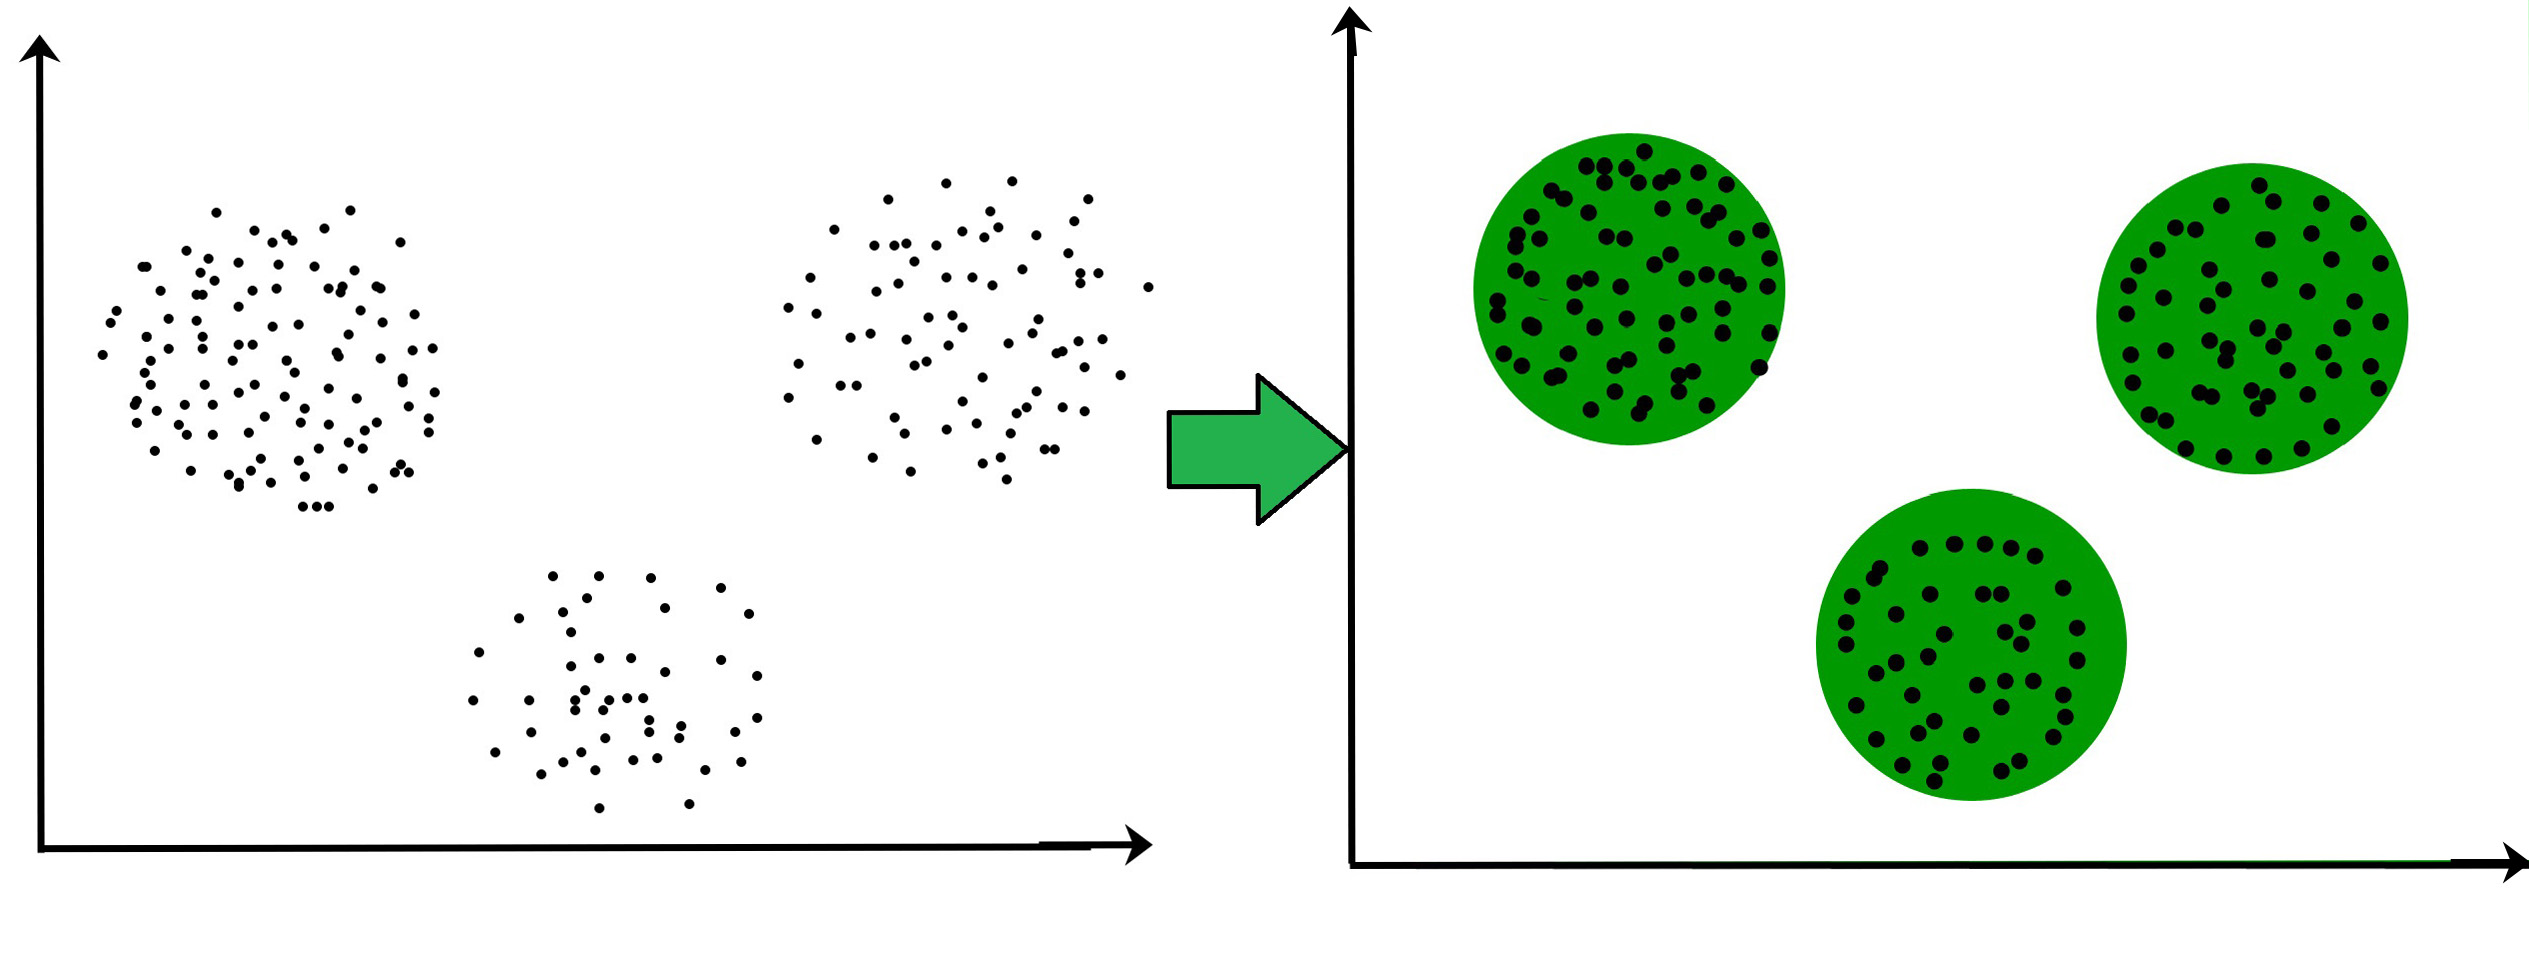

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [ ]:
X, _ = make_blobs(n_samples=1000, random_state=42)

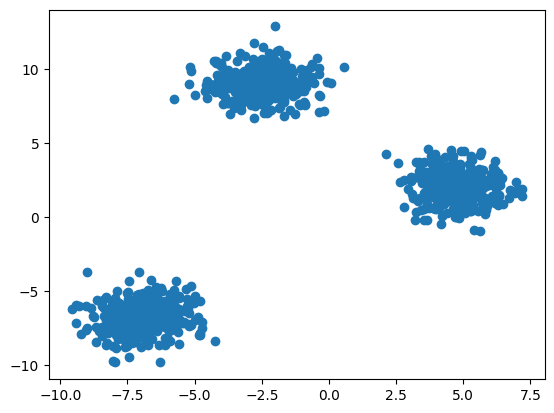

In [ ]:
plt.scatter(X[:, 0], X[:, 1])

In [ ]:
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)
y_pred = kmeans.fit_predict(X)

Każdemu z obiektów zostają przypisane etykiety skupień.

In [ ]:
y_pred

array([0, 0, 1, 2, 2, 0, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 1, 0,
       0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 1, 2, 0,
       2, 0, 2, 2, 0, 1, 0, 2, 1, 0, 2, 0, 2, 2, 2, 1, 1, 2, 0, 0, 2, 2,
       0, 1, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0,
       2, 2, 2, 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 2, 0, 1, 1, 2, 1, 2,
       0, 1, 1, 1, 2, 1, 0, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1,
       1, 0, 2, 0, 2, 1, 1, 1, 2, 2, 0, 0, 0, 2, 1, 2, 2, 2, 2, 0, 1, 0,
       2, 1, 2, 1, 2, 0, 1, 2, 2, 1, 2, 2, 1, 1, 0, 0, 1, 2, 2, 1, 2, 0,
       1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 2, 0, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1,
       1, 0, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 0, 0, 1, 1, 2, 0, 2, 0, 1,
       0, 0, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 2, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 2, 1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1,
       0, 0, 1, 2, 2, 0, 1, 2, 1, 1, 2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 2,
       2, 1, 2, 0, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0,

Za pomocą atrybutu `cluster_centers_` można uzyskać dostęp do współrzędnych centroidów w przestrzeni metrycznej.

In [ ]:
kmeans.cluster_centers_

array([[-6.86656253, -6.78519427],
       [ 4.7286341 ,  2.05557266],
       [-2.52414179,  9.00394283]])

Funkcja `scatter` umożliwia określenie koloru dla poszczególnych punktów za pomocą parametru `c`. Warto w tym celu wykorzystać obiekt `y_pred`, który zawiera identyfikatory skupień dla każdego z obiektów. Mogą one z powodzeniem posłużyć jako ich kolory.

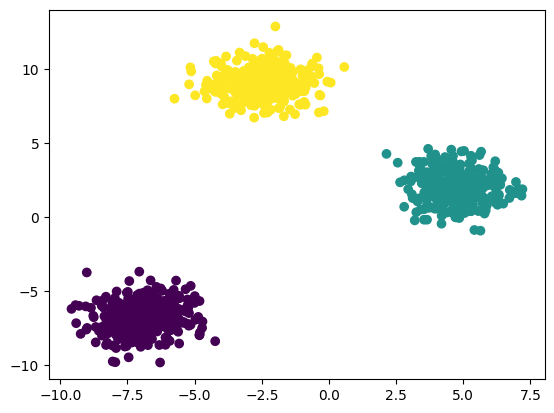

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

W niektórych przypadkach może być pożądane dokonanie tzw. *miękkiej analizy skupień*, która w przewciwieństwie do wariantu twardego, wyznacza stopień przynależności do danego skupienia zamiast konkretnej etykiety. W tym celu należy użyć metody `transform` zamiast `predict`. Wynikiem będzie zwrócona odległość do każdego z centroidów. Im mniejsza, tym dany obiekt bardziej pasuje do konkretnego skupienia.

In [ ]:
kmeans.transform(X)

array([[ 0.44520713, 14.58751032, 16.6486596 ],
       [ 0.75713661, 13.88023013, 15.99816636],
       [14.95341819,  0.46961523, 10.39247064],
       ...,
       [15.53062268,  2.75320856,  7.61363037],
       [13.86404837,  0.74842498,  9.74973926],
       [ 0.65068585, 15.22329206, 16.82785765]])

Jako miarę jakości segmentacji obiektów można wykorzystać *bezwładność*, która jest wyznaczana na podstawie sumy kwadratów odległości między obiektami, a ich najbliższymi centroidami. Mniejsza wartość oznacza dokładniejszą segmentację. Warto zauważyć, że jest to wartość względna, która może być ze sobą porównywalna jedynie dla tego samego zbioru danych. Wartość bezwładności jest dostępna w atrybucie `inertia_`.

In [ ]:
kmeans.inertia_

1950.8814994726636

### Przyspieszone k-średnich

Algorytm *przyspieszone k-średnich* to usprawnienie oryginalnej metody k-średnich, które polega na pomijaniu niektórych obliczeń odległości między punktami, a centroidami na podstawie nierówności trójkąta oraz śledzenia ograniczenia dolnego i górnego w/w odległości. Warto mieć na uwadze fakt, że w niektórych przypadkach wspomniane usprawnienie prowadzi do efektu odwrotnego - proces klasteryzacji wydłuża się zamiast skracać.

W celu wykorzystania tej metody należy wprowadzić parametr `algorithm='elkan'` do inicjalizatora klasy KMeans.

In [ ]:
kmeans = KMeans(n_clusters=3, n_init='auto', algorithm='elkan', random_state=42)
y_pred = kmeans.fit_predict(X)

In [ ]:
y_pred

array([0, 0, 1, 2, 2, 0, 1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 1, 0,
       0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 1, 2, 0,
       2, 0, 2, 2, 0, 1, 0, 2, 1, 0, 2, 0, 2, 2, 2, 1, 1, 2, 0, 0, 2, 2,
       0, 1, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0,
       2, 2, 2, 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 2, 0, 1, 1, 2, 1, 2,
       0, 1, 1, 1, 2, 1, 0, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1,
       1, 0, 2, 0, 2, 1, 1, 1, 2, 2, 0, 0, 0, 2, 1, 2, 2, 2, 2, 0, 1, 0,
       2, 1, 2, 1, 2, 0, 1, 2, 2, 1, 2, 2, 1, 1, 0, 0, 1, 2, 2, 1, 2, 0,
       1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 2, 0, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1,
       1, 0, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 0, 0, 1, 1, 2, 0, 2, 0, 1,
       0, 0, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 2, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 2, 1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1,
       0, 0, 1, 2, 2, 0, 1, 2, 1, 1, 2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 2,
       2, 1, 2, 0, 0, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0,

### k-średnich z minigrupami

Algorytm *k-średnich z minigrupami* to kolejne usprawnienie oryginalnej metody k-średnich, która może w szczególności sprawdzić się podczas pracy z dużymi zbiorami danych, które nie mieszczą się w pamięci operacyjnej. W tym przypadku podczas każdej iteracji algorytm nie wyznacza przesunięć centroidów na podstawie całwgo zbioru danych, a jedynie na podstawie minigrup czyli podzbiorów oryginalnego zbioru danych. Zastosowanie takiego podejścia sprawia, że w każdej iteracji centroidy przesuwają się nieznacznie, co wpływa pozytywnie na czas działania algorytmu oraz zużycie pamięci.

W przypadku algorytmu k-średnich z minigrupami zachodzi zmiana interfejsu. Należy wykorzystać klasę `MiniBatchKMeans`. Podstawowe parametry inicjalizatora wraz z metodami pozostają niezmienne względem klasy `KMeans`.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=3, n_init='auto', random_state=42)
y_pred = kmeans.fit_predict(X)

In [ ]:
y_pred

array([1, 1, 0, 2, 2, 1, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 0, 1,
       1, 1, 0, 2, 2, 2, 0, 0, 1, 1, 0, 2, 2, 1, 1, 0, 1, 1, 2, 0, 2, 1,
       2, 1, 2, 2, 1, 0, 1, 2, 0, 1, 2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 2, 2,
       1, 0, 0, 2, 1, 2, 0, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 2, 0, 1, 0, 1,
       2, 2, 2, 2, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 1, 0, 0, 2, 0, 2,
       1, 0, 0, 0, 2, 0, 1, 1, 0, 2, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 2, 0,
       0, 1, 2, 1, 2, 0, 0, 0, 2, 2, 1, 1, 1, 2, 0, 2, 2, 2, 2, 1, 0, 1,
       2, 0, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2, 0, 0, 1, 1, 0, 2, 2, 0, 2, 1,
       0, 1, 0, 1, 2, 0, 2, 0, 2, 1, 2, 1, 2, 1, 0, 2, 0, 0, 2, 1, 0, 0,
       0, 1, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 1, 1, 0, 0, 2, 1, 2, 1, 0,
       1, 1, 0, 2, 1, 2, 2, 0, 1, 2, 2, 1, 2, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 2, 0, 2, 0, 2, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1, 0,
       1, 1, 0, 2, 2, 1, 0, 2, 0, 0, 2, 1, 2, 1, 1, 0, 1, 0, 1, 0, 0, 2,
       2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 0, 1, 1, 2, 1,

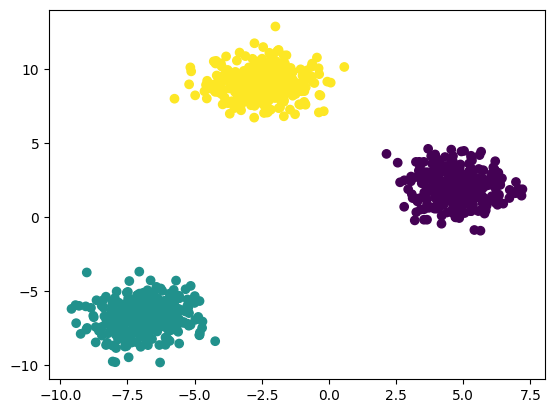

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

In [ ]:
kmeans.inertia_

1951.2840560581174

## Wyznaczanie optymalnej liczby skupień

Do tej pory liczba skupień wyznaczana była odgórnie za pomocą interfejsu klas realizujących działanie algorytmu w postaci parametru `n_clusters`. Wskazanie dobrej liczby skupień wymagało dokonania wizualnej analizy zbioru danych. W przypadku zbioru, który można przedstawić na płaszczyźnie, zadanie może nie być tak złożone, jak w przypadku zbiorów o większej liczbie wymiarów. W tym przypadku maksymalizacji *bezwładności* może nie być dobrym rozwiązaniem - wskaźnik ten maleje wraz ze zwiększaniem liczby skupień.

Zdecydowanie lepszym rozwiązaniem jest wykorzystanie *wyniku profilu* będącego uśrednioną wartością *współczynnika profilu* wszystkich obiektów, który jest wyznaczany następująco: $\frac{b - a}{max(a, b)}$, gdzie:
- $a$ - średnia odległośćdo pozostałych przykładów w danym skupieniu (średnia odległość wewnątrz skupienia),
- $b$ - średnia odległość do najbliższej grupy (średnia odległość do przykładów znajdujących się w najbliższym sąsiadującym skupieniu).

*Współczynnik profilu* przyjmuje wartości od -1 do 1, gdzie wartość bliska 1 oznacza, że obiekt znajduje się wewnątrz swojego skupienia i daleko od innych grup, 0 - obiekt znajduje się na granicy skupienia, -1 - obiekt został przypisany do niewłaściwego skupienia.

*Wynik profilu* można wyznaczyć za pomocą funkcji `silhouette_score`.

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
silhouette_score(X, y_pred)

0.8435705873891368

Stosując tę metodę dla różnej liczby skupień można znaleźć optimum generujące najwyższy wynik profilu.

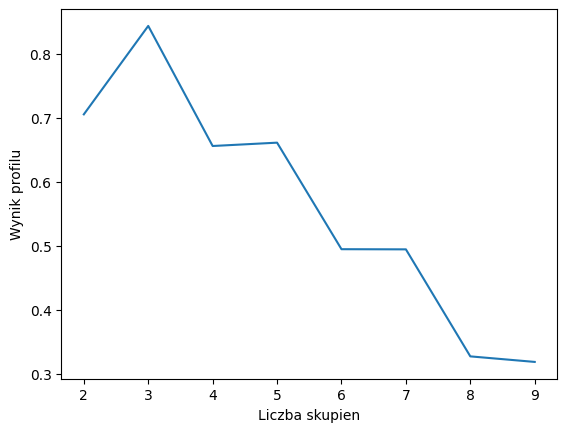

In [ ]:
silhouette_scores = []
clusters = np.arange(2, 10)

for k in clusters:
  kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
  y_pred = kmeans.fit_predict(X)
  score = silhouette_score(X, y_pred)
  silhouette_scores.append(score)

plt.xlabel('Liczba skupien')
plt.ylabel('Wynik profilu')

plt.plot(clusters, silhouette_scores)

plt.show()

Zamiast metody graficznej, można wykorzystać funkcję `argmax`, która zwróci pozycję z największą wartością współczynnika profilu. Warto zauważyć, że pozycja jest powiększona o wartość 2 z uwagi na początek zakresu poszukiwania optymalnej liczby skupień.

In [ ]:
np.argmax(silhouette_scores) + 2

3

## Zadania

1. Wykorzystać metodę *k-średnich* do znalezienia optymalnej liczby skupień dla zbioru `california housing`
2. Korzystając z metody *analizy głównych składowych* znaleźć optimum polegające na jak najmniejszej wartości *współczynnika profilu* przy zachowaniu najmniejszej liczby wymiarów (*).
3. Powtórzyć proces z zadania 2 dla poznanych modyfikacji algorytmu *k-średnich*.
